# Packages & Constants

In [2]:
NUM_CASES    = 300  
TEST_RATIO = .1 # Test ratio for Machine Learning tasks

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import os
import numpy as np
from zipfile import ZipFile
import spacy
nlp = spacy.load('en')
from nltk import ngrams
import string
import pandas as pd
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten
from keras.utils.vis_utils import model_to_dot
import ggplot as gg
from random import shuffle
from gensim.models import Word2Vec
from numpy import *

# Processing the data

In [3]:
cnt = 1
last_action = ""
def counter_message(max_cnt, action):
    """Displays Progress
    """
    global cnt, last_action
    
    #Reset Counter for every new action
    if last_action != action:
        cnt = 1
        last_action = action
    
    #Print Message
    print("\r{}/{}: {}.".format(cnt, max_cnt, action), end=" "*10, flush=True)
    cnt += 1

#Load all Cases into dictionaries
zfile = ZipFile("cases.zip")
caseids = []
raw_texts = {}
years = {}

# Randomly shuffle files and choose as many as we need
members = zfile.namelist()
if NUM_CASES is None:
    NUM_CASES = len(members)
    
processed_files = np.random.permutation(members)[:NUM_CASES]

for case in processed_files:
    year, caseid = case[:-4].split("_")
    with zfile.open(case) as f:
        raw_text = f.read().decode()
    raw_texts[caseid] = raw_text
    years[caseid] = int(year)
    caseids.append(caseid)
    counter_message(NUM_CASES, "opened")

300/300: opened.                              

In [4]:
#Convert to `spacy` documents:
spacy_documents = {}
for caseid in caseids:
    spacy_documents[caseid] = nlp(raw_texts[caseid])
    counter_message(NUM_CASES, "converted")   

300/300: converted.                    

In [481]:
#Lemmatize corpus and remove any punctuation.

def normalize(token):
    """Normalize Token. Get Lemma (base form) and remove any punctuation
    """
    lemma = token.lemma_
    nopunct = lemma.translate(str.maketrans('', '', string.punctuation))
    return nopunct

noun_ngrams = {}
total_ngrams = []
word_counts= {}

# Lemmatize Cases
for caseid in caseids:
    tokens = []
    spacy_document = spacy_documents[caseid]
    for token in spacy_document:
        
        if not token.is_punct and not token.is_space: # Ignore spaces (newlines etc) and punctuation
            tokens.append(token)
            norm = normalize(token)
            
            if not norm in word_counts: # We've seen the word for the first time
                word_counts[norm] = 1
            else:                       # We already know this word
                word_counts[norm] += 1
    counter_message(NUM_CASES, "lemmatized")

300/300: lemmatized.                             

In [302]:
#other data from case metadata
case_metadata = pd.read_csv("case_metadata.csv").values

party = {}
judge_id = {}
cites = {}

for a, b, c, d, e, f in case_metadata:
    party[a] = e 
    judge_id[a] = c
    cites[a] = f

# Question 1

Train a word embedding (Word2Vec, GloVe, ELMo, BERT, etc) on your corpus, once with a small window (e.g. 2) and again with a long window (e.g. 16). What do you expect to change for the different window sizes? Pick a sample of 100 words and visualize them in two dimensions, to demonstrate the difference between the models.


In [104]:
# Word2Vec in gensim
from nltk import sent_tokenize, word_tokenize
translator = str.maketrans('','',string.punctuation) 
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

def get_sentences(doc):
    sentences = []
    for raw in sent_tokenize(doc):
        raw2 = [i for i in raw.translate(translator).lower().split() if i not in stop and len(i) < 10]
        raw3 = [stemmer.stem(t) for t in raw2]
        sentences.append(raw3)
    return sentences

texts = pd.Series(raw_texts, name='text')
# word2vec requires sentences as input
sentences = []
#for caseid in caseids:
for doc in texts:
    sentences += get_sentences(doc)
    counter_message(NUM_CASES, "texts")

shuffle(sentences) #sentences in random order

304/300: texts.                   

In [142]:
### train the model with 2 windows
w2v2 = Word2Vec(sentences,  # list of tokenized sentences
               workers = 8, # Number of threads to run in parallel
               size=300,  # Word vector dimensionality     
               min_count =  25, # Minimum word count  
               window = 2, # Context window size      
               sample = 1e-3, # Downsample setting for frequent words
               )

# done training, so delete context vectors
w2v2.init_sims(replace=True)

In [143]:
### train the model with 16 windows
w2v16 = Word2Vec(sentences,  # list of tokenized sentences
               workers = 8, # Number of threads to run in parallel
               size=300,  # Word vector dimensionality     
               min_count =  25, # Minimum word count  
               window = 16, # Context window size      
               sample = 1e-3, # Downsample setting for frequent words
               )

# done training, so delete context vectors
w2v16.init_sims(replace=True)

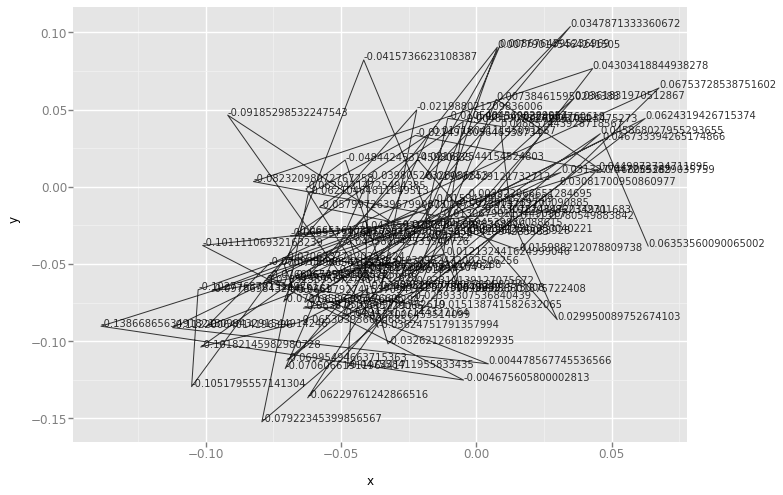

In [198]:
vecW2 = w2v2.wv.vectors
vecW2 = vecW2[:100]
vecW16 = w2v16.wv.vectors
vecW16 = vecW16[:100]

dfv = pd.DataFrame({'x': year[:100], 'y': year[:100]})

dfv['x'] = vecW2
dfv['y'] = vecW16
    
chart = gg.ggplot(dfv, gg.aes(x='x', y='y', label='x') ) \
                      + gg.geom_text(size=10, alpha=.8, label='y') 
chart.show()

**No obvious observable impact on changing the window size has been noticed**

# Question 2

Train separate word embeddings for Republican and Democrat judges. Use your word embeddings to list the adjectives most associated with a social group or concept of your choice, and analyze differences by judge party.


In [487]:
adjectivess = {}
for caseid in caseids:
    tokens = []
    spacy_document = spacy_documents[caseid]
    adjectives = []
    for token in spacy_document:
        if token.pos_ == "ADJ": 
            adjectives.append(token)   # Stores 3-grams for this case
                
    adjectivess[caseid] = adjectives
    counter_message(NUM_CASES, "finished")

600/300: finished.                                                                                                                                                                                                                                                                                                                                

In [472]:
#Separating data into categories based on party affiliations
p = list()
for caseid in caseids:
    p.append(party[caseid])
        
p = pd.DataFrame(p)
p.fillna(0,inplace=True)
pp = p.values

Yr = pd.DataFrame([i for i,_ in enumerate(pp) if _[0] == 1])
Yd = pd.DataFrame([i for i,_ in enumerate(pp) if _[0] == 0])

def indexedData(Y,data):
    Ydata = list(range(len(Y)))
    for c in range(len(Y)):
        Ydata[c] = data[caseids[Y[0][c]]]
    Ydata = pd.DataFrame(Ydata)
    Ydata.fillna(0,inplace=True)
    Ydata = list(Ydata[0])
    return Ydata

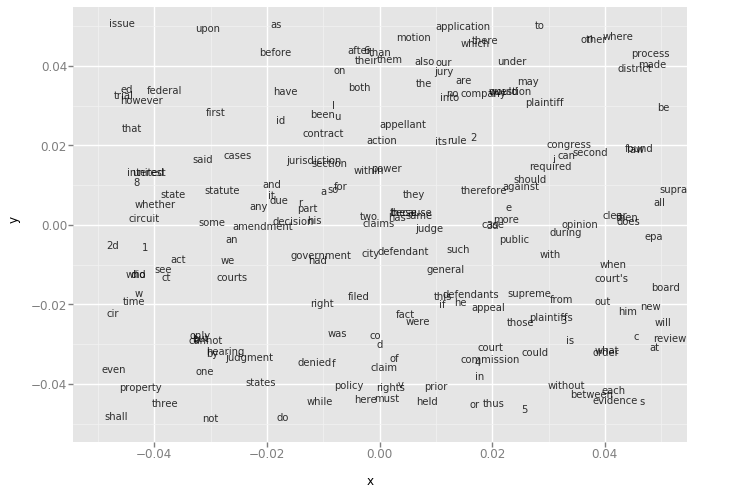

In [492]:
#Data & word embeddings for republicans
Yrcites = indexedData(Yr,cites)
textsR = indexedData(Yr,texts)

# convert documents to sequences of word indexes
from keras.preprocessing.text import Tokenizer
num_words = 200
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(textsR)
sequences = tokenizer.texts_to_sequences(textsR)

# represent data as numrows x maxlen matrix
from keras.preprocessing.sequence import pad_sequences
maxlen = max([len(sent) for sent in sequences]) 

X = pad_sequences(sequences, maxlen=maxlen)
Y = Yrcites

# Model setup
model = Sequential()
model.add(Embedding(num_words,
                    2,
                    input_length=maxlen)) # sequence length
model.add(Flatten()) # 86*2 = 172 dims
model.add(Dense(2))
model.add(Dense(1))
model.compile(optimizer='adam',loss='binary_crossentropy')
dot = model_to_dot(model, show_shapes=True, show_layer_names=False)

# show the vectors
df0 = pd.DataFrame(list(tokenizer.word_index.items()),
                  columns=['word', 'word_index']).sort_values('word_index')[:num_words]

for i in range(1):
    if i > 0:
        model.fit(X,Y,epochs=1, validation_split=.2)

    word_vectors = model.layers[0].get_weights()[0]
    df0['x'] = word_vectors[:,0]
    df0['y'] = word_vectors[:,1]
    chart = gg.ggplot(df0, gg.aes(x='x', y='y', label='word') ) \
                      + gg.geom_text(size=10, alpha=.8, label='word') 
    chart.show()

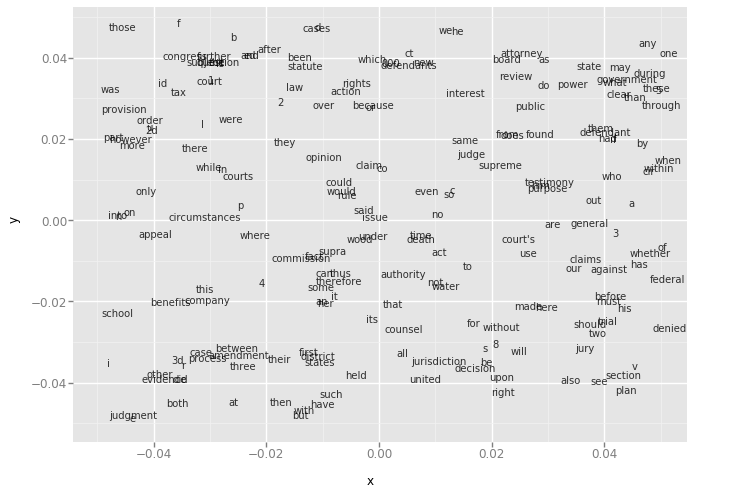

In [480]:
#Data & word embeddings for democrats
Ydcites = indexedData(Yd,cites)
textsD = indexedData(Yd,texts)

# convert documents to sequences of word indexes
from keras.preprocessing.text import Tokenizer
num_words = 200
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(textsD)
sequences = tokenizer.texts_to_sequences(textsD)

# represent data as numrows x maxlen matrix
from keras.preprocessing.sequence import pad_sequences
maxlen = max([len(sent) for sent in sequences]) 

X = pad_sequences(sequences, maxlen=maxlen)
Y = Ydcites

# Model setup
model = Sequential()
model.add(Embedding(num_words,
                    2,
                    input_length=maxlen)) # sequence length
model.add(Flatten()) # 86*2 = 172 dims
model.add(Dense(2))
model.add(Dense(1))
model.compile(optimizer='adam',loss='binary_crossentropy')
dot = model_to_dot(model, show_shapes=True, show_layer_names=False)

# show the vectors
df0 = pd.DataFrame(list(tokenizer.word_index.items()),
                  columns=['word', 'word_index']).sort_values('word_index')[:num_words]

for i in range(1):
    if i > 0:
        model.fit(X,Y,epochs=1, validation_split=.2)

    word_vectors = model.layers[0].get_weights()[0]
    df0['x'] = word_vectors[:,0]
    df0['y'] = word_vectors[:,1]
    chart = gg.ggplot(df0, gg.aes(x='x', y='y', label='word') ) \
                      + gg.geom_text(size=10, alpha=.8, label='word') 
    chart.show()

# Question 3

Implement one of the causal inference methods from Lecture 12 (choose one of the following options):
Look at the effect of text features on citations or reversal (Fong and Grimmer 2016, Hartford et al 2017, or Wang and Blei 2018)
Look at the effect of political party on citations or reversal holding text features constant (Roberts-Stewart-Nielsen 2018 matching method or Chernozhukov et al 2017 double ML method).
Look at heterogeneous effects of political party on citations or reversal depending on text features (Wager and Athey 2017).


**I'm investigating the effect of different text features settings on reversal linear regression performance**

In [519]:
# Load outcomes into dictionary
outcomes = {}
case_reversed = pd.read_csv("case_reversed.csv").values
for caseid, outcome in case_reversed:
    outcomes[caseid] = outcome

y = []

for caseid in caseids:
    y.append(outcomes[caseid])

In [528]:
#X holding the first type of text features 
X = []

# building ngram for features
for caseid in caseids:
    tokens = []
    spacy_document = spacy_documents[caseid]
    for token in spacy_document:   
        tokens.append(token)
        norm = normalize(token)

    noun_ngram = []
    for ngram in ngrams(tokens, 3): # iterate over all 3-grams
        if ngram[2].pos_ == "NOUN": # check if last word is a noun
            curr_ngram = (normalize(ngram[0]),
                               normalize(ngram[1]),
                               normalize(ngram[2]))
            noun_ngram.append(curr_ngram)   # Stores 3-grams for this case
            total_ngrams.append(curr_ngram) # Stores 3-grams for all cases
    
    noun_ngrams[caseid] = noun_ngram
    
# Get most common n_grams
most_common = Counter(total_ngrams).most_common()

for caseid in caseids:
    current_ngram = Counter(noun_ngrams[caseid])
    features = np.zeros(len(most_common))
    for i in range(len(most_common)):
        ngram = most_common[i][0]
        if ngram in current_ngram: #Only add most common 3-gram frequencies
            features[i] = current_ngram[ngram]
    X.append(features)

# convert to numpy array
X = np.array(X)

#standardize; maintain sparsity by not taking out the mean
X = X / np.std(X, axis=0)

where_are_NaNs = isnan(X)
X[where_are_NaNs] = 0

In [530]:
#outcome and link features with outcome

#Shuffle Dataset
permutation = np.random.permutation(X.shape[0])
X = X[permutation]
#y = y[permutation]

#Split into test & train dataset

test_amount = int(X.shape[0]*TEST_RATIO)

test_X = X[:test_amount]
test_y = y[:test_amount]
train_X = X[test_amount:]
train_y = y[test_amount:]

# Fit Logistic Regression Model with standard parameters
clf = LogisticRegression().fit(train_X, train_y)

# Make prediction
y_pred = clf.predict(test_X)

# Determine accuracy
accuracy = accuracy_score(y_pred, test_y)
f1 = f1_score(y_pred, test_y)

print("accuracy: {:.4f}".format(accuracy))
print("f1 score: {:.4f}".format(f1))

# Apply Grid Search
parameters = {'penalty':('l1', 'l2'), 'C':[.1, 10]}
lreg = LogisticRegression()
clf = GridSearchCV(lreg, parameters, cv=5)
clf.fit(train_X,train_y)

# Make Predictions
y_pred = clf.predict(test_X)

# Calculate accuracy
accuracy = accuracy_score(y_pred, test_y)
f1 = f1_score(y_pred, test_y)

params = clf.get_params()
C_opt = params['estimator__C']
penalty_opt = params['estimator__penalty']

print("Optimal C:       {}".format(C_opt))
print("Optimal Penalty: {}".format(penalty_opt))
print("accuracy: {:.4f}".format(accuracy))
print("f1 score: {:.4f}".format(f1))

accuracy: 0.6333
f1 score: 0.7755
Optimal C:       1.0
Optimal Penalty: l2
accuracy: 0.6333
f1 score: 0.7755


In [533]:
#X holding the second type of text features 
X = []

# building ngram for features
for caseid in caseids:
    tokens = []
    spacy_document = spacy_documents[caseid]
    for token in spacy_document:   
        tokens.append(token)
        norm = normalize(token)

    noun_ngram = []
    for ngram in ngrams(tokens, 3): # iterate over all 3-grams
        if ngram[0].pos_ == "VERB": # check if last word is a noun
            curr_ngram = (normalize(ngram[0]),
                               normalize(ngram[1]),
                               normalize(ngram[2]))
            noun_ngram.append(curr_ngram)   # Stores 3-grams for this case
            total_ngrams.append(curr_ngram) # Stores 3-grams for all cases
    
    noun_ngrams[caseid] = noun_ngram
    
# Get most common n_grams
most_common = Counter(total_ngrams).most_common()

for caseid in caseids:
    current_ngram = Counter(noun_ngrams[caseid])
    features = np.zeros(len(most_common))
    for i in range(len(most_common)):
        ngram = most_common[i][0]
        if ngram in current_ngram: #Only add most common 3-gram frequencies
            features[i] = current_ngram[ngram]
    X.append(features)

# convert to numpy array
X = np.array(X)

#standardize; maintain sparsity by not taking out the mean
X = X / np.std(X, axis=0)

where_are_NaNs = isnan(X)
X[where_are_NaNs] = 0

In [534]:
#Load outcome and link features with outcome

#Shuffle Dataset
permutation = np.random.permutation(X.shape[0])
X = X[permutation]

#Split into test & train dataset

test_amount = int(X.shape[0]*TEST_RATIO)

test_X = X[:test_amount]
test_y = y[:test_amount]
train_X = X[test_amount:]
train_y = y[test_amount:]

# Fit Logistic Regression Model with standard parameters
clf = LogisticRegression().fit(train_X, train_y)

# Make prediction
y_pred = clf.predict(test_X)

# Determine accuracy
accuracy = accuracy_score(y_pred, test_y)
f1 = f1_score(y_pred, test_y)

print("accuracy: {:.4f}".format(accuracy))
print("f1 score: {:.4f}".format(f1))

# Apply Grid Search
parameters = {'penalty':('l1', 'l2'), 'C':[.1, 10]}
lreg = LogisticRegression()
clf = GridSearchCV(lreg, parameters, cv=5)
clf.fit(train_X,train_y)

# Make Predictions
y_pred = clf.predict(test_X)

# Calculate accuracy
accuracy = accuracy_score(y_pred, test_y)
f1 = f1_score(y_pred, test_y)

params = clf.get_params()
C_opt = params['estimator__C']
penalty_opt = params['estimator__penalty']

print("Optimal C:       {}".format(C_opt))
print("Optimal Penalty: {}".format(penalty_opt))
print("accuracy: {:.4f}".format(accuracy))
print("f1 score: {:.4f}".format(f1))

accuracy: 0.5667
f1 score: 0.6977
Optimal C:       1.0
Optimal Penalty: l2
accuracy: 0.5667
f1 score: 0.6977


**No observed major effect of varying text features on linear regression with outcome**